In [299]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

In [300]:
#iterate over files
content = []
files = glob.glob('../zillow_files/apartments_scraped_*')
for file in files:
    initial_load = pd.read_csv(file, index_col=0)
    content.append(initial_load)
print(content)

df = pd.concat(content)

# convert date column from object to datetime
df['Date_Webscraped'] = df['Date_Webscraped'].astype('datetime64')

[                              Address   Price  Beds  Baths Neighborhood  \
0                  837 Almond St19125  1995.0     4      1     Fishtown   
1     1050 E Montgomery Ave #30919125  1950.0     3      1     Fishtown   
2             438 Memphis St #4219125  1700.0     1      1     Fishtown   
3    2636 Belgrade St #810712D4B19125  1867.0     2      2     Fishtown   
4                  1722 Blair St19125  1995.0     4      2     Fishtown   
..                                ...     ...   ...    ...          ...   
97      425 S Carlisle St APT 2C19146  1450.0     1      1  Rittenhouse   
98      271 S 15th St #1AC437A0419102  1310.0     0      1  Rittenhouse   
99        135 S 20th St #163863919103  1300.0     0      1  Rittenhouse   
100      1401 Walnut St #144842819103  4950.0     2      2  Rittenhouse   
101          1712 Pine St APT 2R19103  1395.0     1      1  Rittenhouse   

      Latitude  Longitude Date_Webscraped  
0    39.974865 -75.124954      2022-04-05  
1    39.96

In [301]:
#check for null values
df.isna().sum()

Address            0
Price              0
Beds               0
Baths              0
Neighborhood       0
Latitude           0
Longitude          0
Date_Webscraped    0
dtype: int64

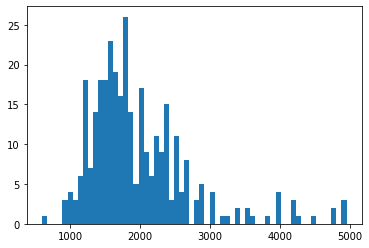

In [302]:
#see distribution of price
plt.hist(df.Price, bins=len(set(df.Beds))*10)
plt.show()

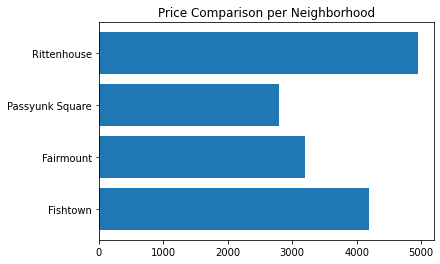

In [303]:
#maybe a good start but other factors like Beds could affect this
plt.barh(df.Neighborhood, df.Price)
plt.title('Price Comparison per Neighborhood')
plt.show()

In [304]:
#Passyunk Square is the only neighborhood with a 5 bed apt listing
#this is partly skewing the comparison above
df[df['Beds'] > 4]

,Address,Price,Beds,Baths,Neighborhood,Latitude,Longitude,Date_Webscraped
69,1011 Federal St19147,2400.0,5,2,Passyunk Square,39.93477,-75.16079,2022-04-10


In [305]:

beds_df = df.groupby(['Neighborhood','Beds']).agg(Total_Count=pd.NamedAgg(column="Beds", aggfunc="count"))


In [306]:
beds_df.loc[('Fairmount', 5), 'Total_Count'] = 0
beds_df.loc[('Fishtown', 5), 'Total_Count'] = 0
beds_df.loc[('Passyunk Square', 0), 'Total_Count'] = 0
beds_df.loc[('Rittenhouse', 5), 'Total_Count'] = 0

beds_df.sort_index(0, inplace=True)

/var/folders/zy/z96pcm290zq7tns2z12czq_c0000gn/T/ipykernel_1519/2941674489.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  beds_df.sort_index(0, inplace=True)


In [307]:
beds_df

Total_Count
Neighborhood    Beds             
Fairmount       0             2.0
                1            23.0
                2            47.0
                3            24.0
                4             3.0
                5             0.0
Fishtown        0             5.0
                1            19.0
                2            44.0
                3            23.0
                4            11.0
                5             0.0
Passyunk Square 0             0.0
                1            18.0
                2            35.0
                3             8.0
                4             1.0
                5             1.0
Rittenhouse     0            13.0
                1            23.0
                2            14.0
                3             4.0
                4             4.0
                5             0.0

In [308]:
category_names = list(set(beds_df.index.get_level_values(1)))
category_names

[0, 1, 2, 3, 4, 5]

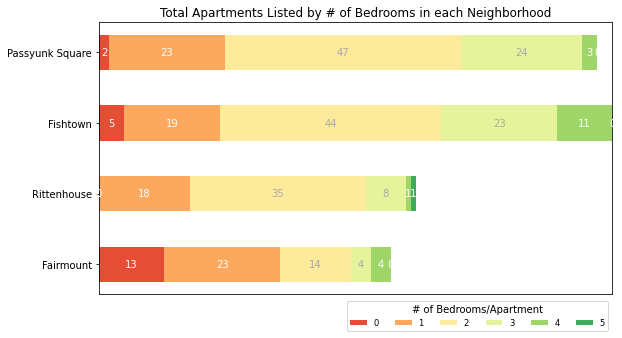

In [309]:
 # preliminary stats-- what's the avg price per bedroom, 
 # and what's the distribution of apartments with different # of bedrooms
 # clearly a lot more apartments with 2 bedrooms are listed than other apartment sizes
 # does the date the data was first scraped affect any of these stats

category_names = list(set(beds_df.index.get_level_values(1)))
labels = list(set(beds_df.index.get_level_values(0)))
data = np.array(list(beds_df.values))
data.shape = (4,6)
data_cum = data.cumsum(axis=1)
category_colors = plt.colormaps['RdYlGn'](
    np.linspace(0.15, 0.85, data.shape[1]))

fig, ax = plt.subplots(figsize=(9.2, 5))
ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, np.sum(data, axis=1).max())
for i, (colname, color) in enumerate(zip(category_names, category_colors)):
    widths = data[:, i]
    starts = data_cum[:, i] - widths
    rects = ax.barh(labels, widths, left=starts, height=0.5,
                    label=colname, color=color)

    r, g, b, _ = color
    text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
    ax.bar_label(rects, label_type='center', color=text_color)
ax.legend(ncol=len(category_names),
            loc='lower right', bbox_to_anchor=(1, -0.15), fontsize='small', title="# of Bedrooms/Apartment")
plt.title("Total Apartments Listed by # of Bedrooms in each Neighborhood")
plt.show()
